In [ ]:
import ebf
import h5py
import tqdm
import numpy as np
import multiprocessing
import astropy.units as u
from astroNN.gaia import absmag_to_fakemag, fakemag_to_mag
import mwdust

drimmel= mwdust.Drimmel03(filter='2MASS H')
combined= mwdust.Combined15(filter='2MASS H')
combined19= mwdust.Combined19(filter='2MASS H')
sfd= mwdust.SFD(filter='2MASS H')

R0 = 8.275 * u.kpc
v0 = [11.1, 252.0, 7.25] * u.km / u.s
z0 = 20.8 * u.pc
bar_angle = 25. / 180.0 * np.pi

bes = ebf.read("/home/henrysky/my_data/MWMgalaxy2.ebf")

x = bes["px"]
y = bes["py"]
z = bes["pz"]
R = np.sqrt(x ** 2 + y ** 2 + z ** 2)
l = bes["glon"]
b = bes["glat"]
a_h_galaxia = 0.591 * bes["exbv_schlegel"]  # extinciton law
x = x - R0.value

h_abs = bes["ubv_h"]

hmag = fakemag_to_mag(absmag_to_fakemag(h_abs), R * u.kpc)

f = h5py.File("MWM2.h5", "w")
f.create_dataset("l", data=l)
f.create_dataset("b", data=b)
f.create_dataset("r", data=R)

combined19= mwdust.Combined19(filter='2MASS H')

def process_single(i):
    return combined19(*i)

delta_i = 10000
current_lowend = 0
current_highend = current_lowend + delta_i

f = h5py.File("MWM2.h5", "r")

aaah = np.zeros(len(f["r"]), dtype=np.float64)

with multiprocessing.Pool(int(multiprocessing.cpu_count()/2)) as p:
    for ii in tqdm.tqdm(range(int((len(f["r"])-current_lowend) / delta_i))):
        l = f["l"][current_lowend:current_highend]
        b = f["b"][current_lowend:current_highend]
        R = f["r"][current_lowend:current_highend]
        data = np.stack([l, b, R]).T
        output = np.array(list(p.imap(process_single, data))).flatten()
        aaah[current_lowend:current_highend] = output
        current_lowend += delta_i
        current_highend += delta_i
    l = f["l"][current_highend:]
    b = f["b"][current_highend:]
    R = f["r"][current_highend: ]
    data = np.stack([l, b, R]).T

    output = np.array(list(p.imap(process_single, data))).flatten()
    aaah[current_highend:] = output
    np.save("aaah.npy", aaah)

Number of star:  9424695


C:\Users\Henry\AppData\Local\Temp/ipykernel_3232/2993629931.py:57: RuntimeWarning: divide by zero encountered in true_divide


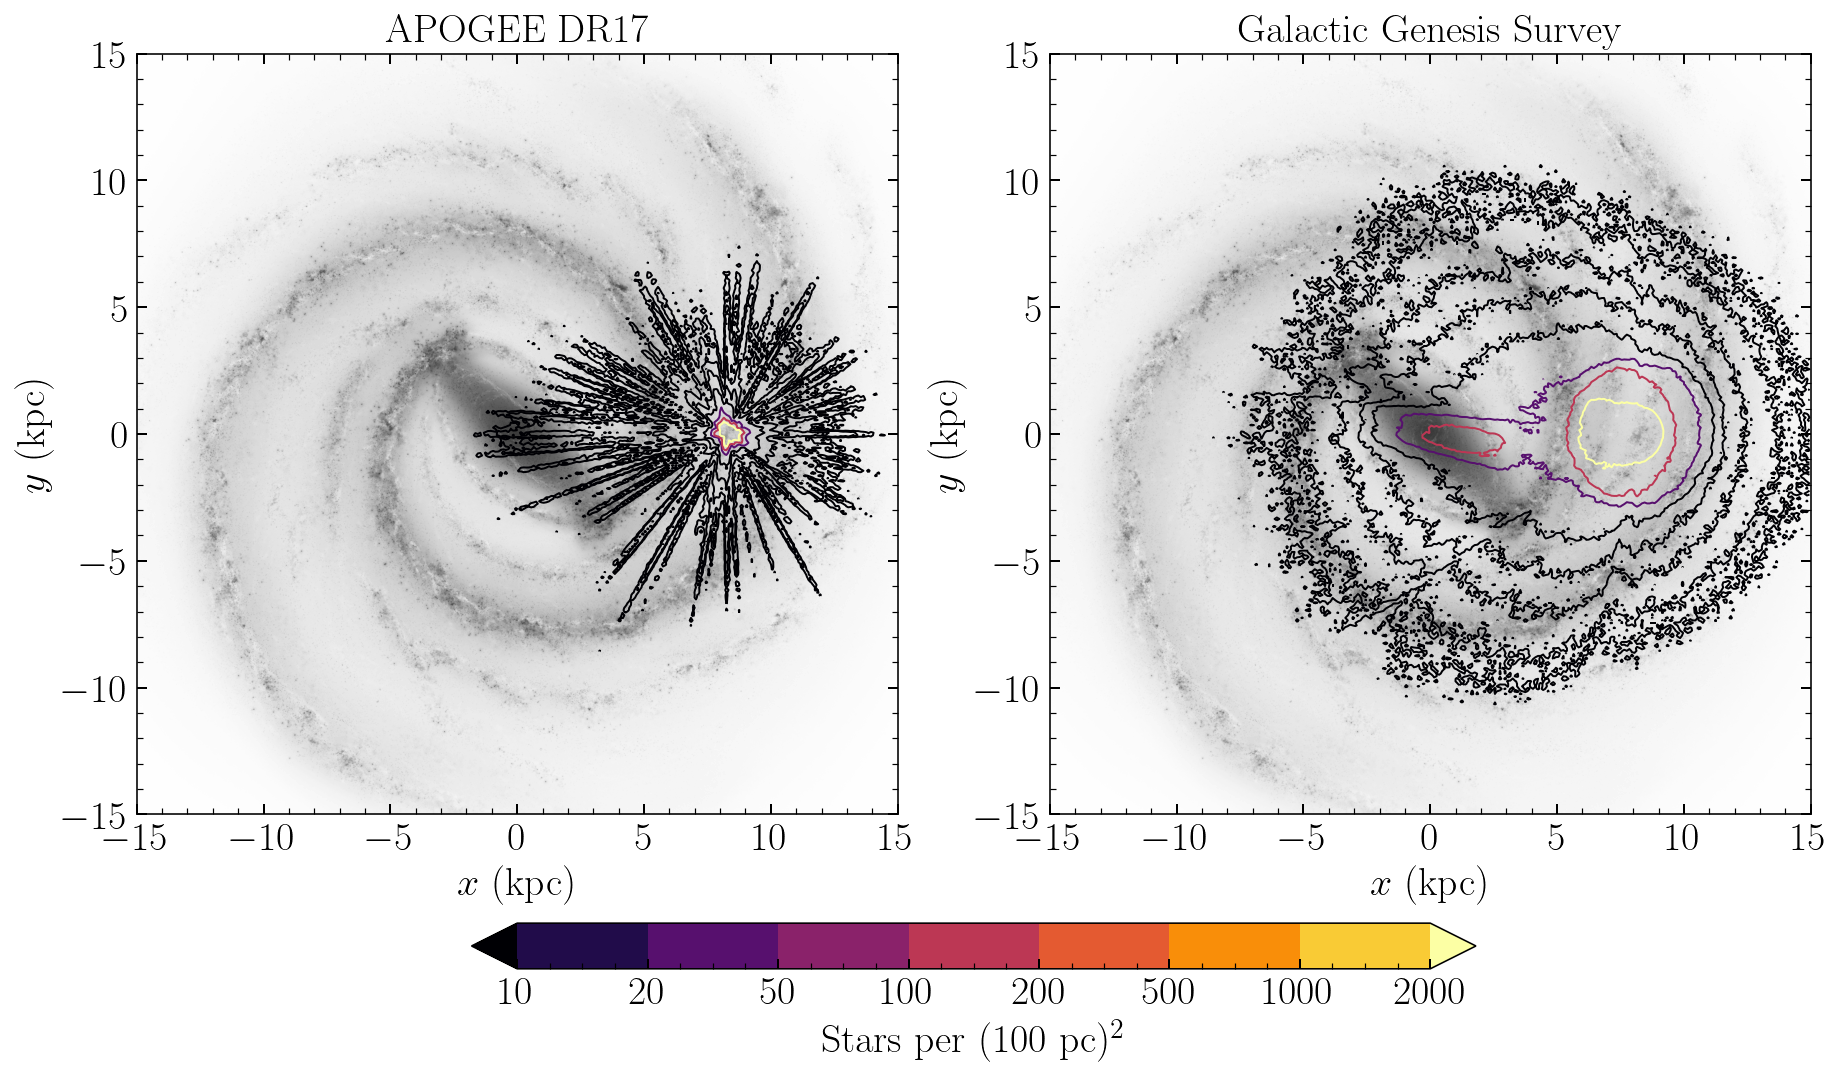

In [5]:
import matplotlib as mpl
import pylab as plt
from astroNN.apogee import allstar, apogee_astronn
from astroNN.gaia import absmag_to_fakemag, fakemag_to_mag
from astroNN.shared.matplotlib import pylab_style
from astropy import units as u
from astropy.coordinates import CartesianDifferential, Galactocentric, SkyCoord
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mw_plot import MWPlot, MWSkyMap
from scipy.stats import binned_statistic_2d

pylab_style(paper=True)

levels = [10, 20, 50, 100, 200, 500, 1000, 2000]
cmap = plt.cm.get_cmap("inferno", 9)

R0 = 8.275 * u.kpc
v0 = [11.1, 240.0, 7.25] * u.km / u.s
z0 = 20.8 * u.pc

###### galaxia processing ######
import ebf

bes = ebf.read("MWMgalaxy2.ebf")

x = bes["px"]
y = bes["py"]
z = bes["pz"]
R = np.sqrt(x ** 2 + y ** 2 + z ** 2)
x = x - R0.value

h_abs = bes["ubv_h"]
a_h = 0.591 * bes["exbv_schlegel"]  # extinciton law

bovy_ah = np.max(np.stack([np.load("aaah.npy"), np.load("aaah_29460000.npy")]), axis=0)

hmag = fakemag_to_mag(absmag_to_fakemag(h_abs), R * u.kpc)
hmag_extincted = hmag + bovy_ah

# targeting
good_idx = (np.abs(z) < 0.5) & (hmag_extincted < 11) & (hmag_extincted > 4)
print("Number of star: ", np.sum(good_idx))
x = -x[good_idx]
y = -y[good_idx]
z = z[good_idx]

counts_ggs, xe_ggs, ye_ggs, binnum = binned_statistic_2d(
    x, y, y, statistic="count", range=[[-15.0, 15.0], [-15.0, 15.0]], bins=(300, 300)
)
###### galaxia processing ######


f_allstar = fits.getdata(allstar(dr=17))
f_gaia = fits.getdata("../apogeework/apogeedr17_syncspec_gaiaedr3_xmatch.fits")
f_astroNN = fits.getdata(apogee_astronn(dr=17))

good_gaia_idx = (f_astroNN["dist"] / f_astroNN["dist_model_error"] > 2) & (
    ~np.isnan(f_astroNN["dist"])
)

skyc_gaia = SkyCoord(
    ra=f_allstar["RA"][good_gaia_idx] * u.deg,
    dec=f_allstar["DEC"][good_gaia_idx] * u.deg,
    distance=f_astroNN["dist"][good_gaia_idx] * u.pc,
    pm_ra_cosdec=f_allstar["GAIAEDR3_PMRA"][good_gaia_idx] * u.mas / u.yr,
    pm_dec=f_allstar["GAIAEDR3_PMDEC"][good_gaia_idx] * u.mas / u.yr,
    radial_velocity=f_allstar["VHELIO_AVG"][good_gaia_idx] * u.km / u.s,
)

v_sun = CartesianDifferential(v0)
gc_frame = Galactocentric(galcen_distance=R0, z_sun=z0, galcen_v_sun=v_sun)

gc_gaia = skyc_gaia.transform_to(gc_frame)
gc_gaia.representation_type = "cylindrical"

data_gaia = np.vstack(
    [
        -gc_gaia.cartesian.x.to(u.kpc).value,
        gc_gaia.cartesian.y.to(u.kpc).value,
        gc_gaia.cartesian.z.to(u.kpc).value,
    ]
).T

# x, y
data_gaia[:, 1] *= -1

x = data_gaia[:, 0]
y = -data_gaia[:, 1]
z = data_gaia[:, 2]

counts, xe, ye, binnum = binned_statistic_2d(
    x, y, y, statistic="count", range=[[-15.0, 15.0], [-15.0, 15.0]], bins=(300, 300)
)

# setup a mw-plot instance of bird's eyes view of the disc
mw2 = MWPlot(
    radius=15 * u.kpc,
    center=(0, 0) * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    grayscale=True,
    annotation=False,
)

# setup subplots with matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# transform the subplots with different style
# mw1.transform(ax1)
# mw2.transform(ax2)

ax1.imshow(
    mw2._img[:, :, 0],
    extent=[-15.0, 15.0, -15.0, 15.0],
    alpha=0.8,
    cmap="gray",
)
ax1.contour(
    (xe[1:] + xe[:-1]) / 2,
    (ye[1:] + ye[:-1]) / 2,
    counts.T,
    levels=levels,
    linewidths=1.0,
    cmap=cmap,
)

# hack to get the colorbar
mappable = ax2.contourf(
    (xe_ggs[1:] + xe_ggs[:-1]) / 2,
    (ye_ggs[1:] + ye_ggs[:-1]) / 2,
    counts_ggs.T,
    levels=levels,
    cmap=cmap,
    zorder=0,
)
ax2.imshow(
    np.ones_like(mw2._img[:, :, 0]) * 255,
    extent=[-15.0, 15.0, -15.0, 15.0],
    zorder=0,
    cmap="gray_r",
)

ax2.imshow(
    mw2._img[:, :, 0],
    extent=[-15.0, 15.0, -15.0, 15.0],
    zorder=1,
    alpha=0.8,
    cmap="gray",
)
mappable = ax2.contour(
    (xe_ggs[1:] + xe_ggs[:-1]) / 2,
    (ye_ggs[1:] + ye_ggs[:-1]) / 2,
    counts_ggs.T,
    levels=levels,
    linewidths=1.0,
    cmap=cmap,
    zorder=2,
)

ax1.set_ylabel("$y\ (\mathrm{kpc})$")
ax1.set_xlabel("$x\ (\mathrm{kpc})$")
ax2.set_ylabel("$y\ (\mathrm{kpc})$")
# ax2.set_yticklabels([])
ax2.set_xlabel("$x\ (\mathrm{kpc})$")
ax1.set_title("APOGEE DR17")
ax2.set_title("Galactic Genesis Survey")
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.BoundaryNorm(
            [10, 20, 50, 100, 200, 500, 1000, 2000], 9, extend="both"
        ),
        cmap=cmap,
    ),
    ax=[ax1, ax2],
    shrink=0.6,
    location="bottom",
    pad=0.1,
    label="Stars per $(100\ \mathrm{pc})^2$"
)
ax2.set_axisbelow(False)
# cbar = fig.colorbar(
#     mappable,
#     ax=[ax1, ax2],
#     shrink=0.6,
#     location="bottom",
#     pad=0.1,
#     label="Density (stars per $[(100\ \mathrm{pc})^2]$)",
# )

# fig.tight_layout()
fig.savefig("mwm_density.pdf", bbox_inches="tight")